<a href="https://colab.research.google.com/github/Akasonal/Twitter-Sentiment-Analysis-using-LSTM/blob/main/Twitter_Disaster_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

{}

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras 
from keras.layers import Embedding,Bidirectional,LSTM,Dropout,Dense
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import metrics
import scikitplot as splt
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import csv

In [3]:
df=pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.shape  #shape of  the dataframe

(7613, 5)

In [5]:
#extracting text and labels as two different variables
text=[]
labels=[]
with open("train.csv","r") as f:
  data_text=csv.reader(f,delimiter=",")
  next(data_text)
  for i in data_text:
    text.append(i[3])
    labels.append(i[4])

In [6]:
print("length to text:",len(text))
print("length of target variables:",len(labels))

length to text: 7613
length of target variables: 7613


## Data Preprocessing

##text Preprocessing
1.removing html tags <br>
2.removing punctuations and whitespace <br>
3.removing stopwords <br>
4.converting text into lower case <br>
5.remove all those word with length less than 3 <br>

In [7]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy
import textblob as TextBlob 
import string

In [8]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
stopwords=set(stopwords.words("english"))
stopwords
ps=PorterStemmer()

In [10]:
#code to convert all the numerical values into text
import inflect
q=inflect.engine()
def numtotext(data):
  temp_str=data.split()
  new_string=[]
  for word in temp_str:
    if word.isdigit():
      temp=q.number_to_words(word)
      new_string.append(temp)
    else:
      new_string.append(word)
  new_string=" ".join(new_string)
  return new_string

In [11]:
final_text=[]
for i in range(len(text)):
      cleaned=re.sub(r"[^a-zA-Z0-9]"," ",text[i]) #removing all those values which are not alphabteical and numerical
      cleaned=re.sub(r'\w+\d+'," ",cleaned)   #removing all the combination of alphabetical and numerical words
      cleaned=cleaned.strip()      #removing whitespcae from the text
      cleaned=cleaned.lower()      #converting all the text into lowercase
      cleaned=numtotext(cleaned)   #convert all the numerical values into text
      cleaned=cleaned.split()
      cleaned=[word for word in cleaned if word not in stopwords if len(word)>3]  #removing stopwords and words with length less than 3
      cleaned=" ".join(cleaned)
      final_text.append(cleaned)

In [12]:
final_text[:10]

['deeds reason earthquake allah forgive',
 'forest fire near ronge sask canada',
 'residents asked shelter place notified officers evacuation shelter place orders expected',
 'people receive wildfires evacuation orders california',
 'sent photo ruby alaska smoke wildfires pours school',
 'rockyfire update california closed directions lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas',
 'hill fire woods',
 'emergency evacuation happening building across street',
 'afraid tornado coming area']

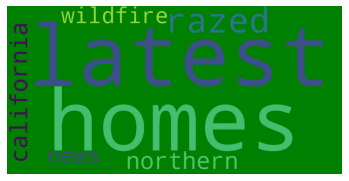

In [13]:
%matplotlib inline
from wordcloud import WordCloud
wc=WordCloud(width=1000,height=500,max_words=500,background_color="green")
wc.generate(cleaned)
plt.imshow(wc)
plt.axis("off")
plt.show()

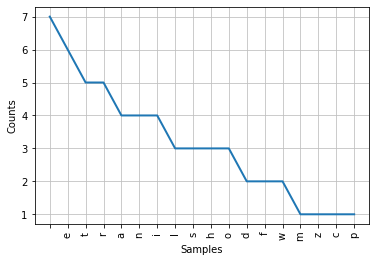

In [14]:
freq_dist=nltk.FreqDist(cleaned)
freq_dist.plot(20)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


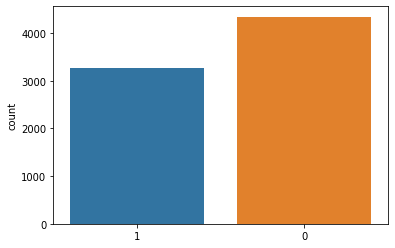

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(labels)
plt.show()

## Hyperparameter Tuning

In [16]:
vocab_size=5000
len_train=0.8
len_sen=150
oov_token="<oov>"
train_sizeX=int(len(final_text)*len_train)
train_sizeY=int(len(labels)*len_train)
x_train=final_text[0:train_sizeX]
x_test=final_text[train_sizeX:]
y_train=df["target"][:train_sizeY]
y_test=df["target"][train_sizeY:]

In [17]:
#extracting train and test dataset from the dataframe
print(f"length of Xtrain : {len(x_train)}")
print(f"length of x_test: {len(x_test)}")
print(f"length of y_train: {len(y_train)}")
print(f"length of y_test : {len(y_test)}")

length of Xtrain : 6090
length of x_test: 1523
length of y_train: 6090
length of y_test : 1523


In [18]:
set(y_train)

{0, 1}

## Word Embedding

In [19]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(final_text)

In [20]:
embed_x_train=tokenizer.texts_to_sequences(x_train)
embed_x_test=tokenizer.texts_to_sequences(x_test)
print(f"original text value :== {x_train[2]}")
print(f"ector form of text value:== {embed_x_train[2]}")

original text value :== residents asked shelter place notified officers evacuation shelter place orders expected
ector form of text value:== [1366, 1257, 1522, 487, 1, 1367, 127, 1522, 487, 1081, 826]


In [21]:
padded_x_train=pad_sequences(embed_x_train,maxlen=len_sen,padding="post")
padded_x_test=pad_sequences(embed_x_test,maxlen=len_sen,padding="post")
print(f"original text value :== {x_train[2]}")
print(f"vector form of text value:== {embed_x_train[2]}")
print(f"embedded x_train after paddig:=={padded_x_train[2]}")

original text value :== residents asked shelter place notified officers evacuation shelter place orders expected
vector form of text value:== [1366, 1257, 1522, 487, 1, 1367, 127, 1522, 487, 1081, 826]
embedded x_train after paddig:==[1366 1257 1522  487    1 1367  127 1522  487 1081  826    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


## Model Preparation

In [22]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=100,input_length=len_sen))
#here we will use stacked bidirectional layer to provide more learning to the dataset
model.add(LSTM(128,return_sequences=True,activation="relu"))
model.add(LSTM(128,return_sequences=True,activation="relu"))
model.add(LSTM(128,return_sequences=True,activation="relu"))
model.add(LSTM(128,return_sequences=False,activation="relu"))
model.add(Dense(48,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 150, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 48)                6192      
_________________________________________________________________
dropout (Dropout)            (None, 48)                0

In [23]:
model.compile(loss=['binary_crossentropy'],optimizer="adam",metrics=["accuracy"])

In [25]:
history=model.fit(padded_x_train,y_train,validation_data=(padded_x_test,y_test),epochs=10,batch_size=150,verbose=1)

Epoch 1/10
41/41 [==============================] - 33s 807ms/step - loss: 0.6813 - accuracy: 0.5793 - val_loss: 0.6947 - val_accuracy: 0.5345
Epoch 2/10
41/41 [==============================] - 33s 809ms/step - loss: 0.6808 - accuracy: 0.5793 - val_loss: 0.6943 - val_accuracy: 0.5345
Epoch 3/10
41/41 [==============================] - 32s 786ms/step - loss: 0.6811 - accuracy: 0.5793 - val_loss: 0.6954 - val_accuracy: 0.5345
Epoch 4/10
41/41 [==============================] - 33s 800ms/step - loss: 0.6807 - accuracy: 0.5793 - val_loss: 0.6935 - val_accuracy: 0.5345
Epoch 5/10
41/41 [==============================] - 32s 788ms/step - loss: 0.6810 - accuracy: 0.5793 - val_loss: 0.6965 - val_accuracy: 0.5345
Epoch 6/10
41/41 [==============================] - 33s 798ms/step - loss: 0.6808 - accuracy: 0.5793 - val_loss: 0.6952 - val_accuracy: 0.5345
Epoch 7/10
41/41 [==============================] - 34s 822ms/step - loss: 0.6809 - accuracy: 0.5793 - val_loss: 0.6946 - val_accuracy: 0.5345

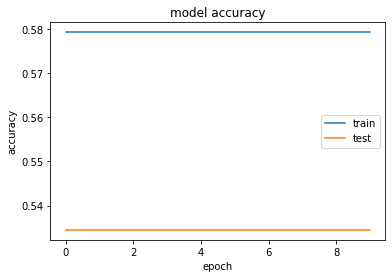

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

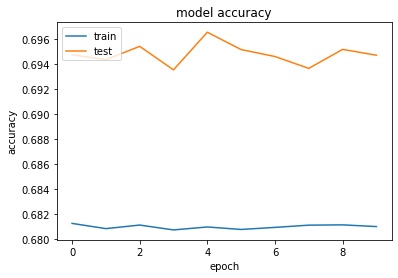

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
predicted=model.predict_classes(padded_X_test)
predicted[0]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0]

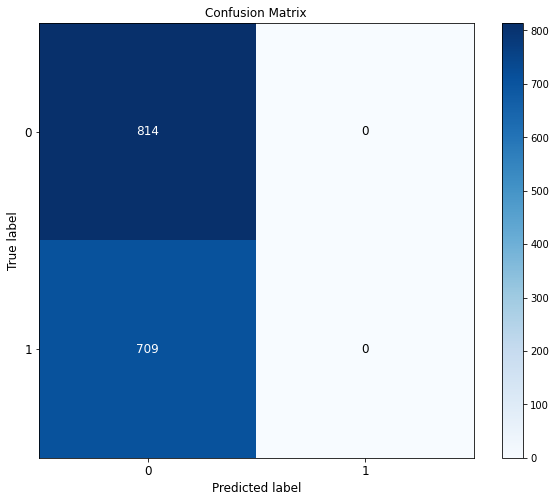

In [45]:
from sklearn import metrics
splt.metrics.plot_confusion_matrix(y_test,predicted,figsize=(10,8),text_fontsize="large")
plt.show()

## Checking result on unseen data

In [54]:
def predict(data):
  data=tokenizer.texts_to_sequences(data)
  data=pad_sequences(data,maxlen=150,padding="post")
  result=model.predict_classes(data)
  if result==0:
    return "Non Disastrous"
  else:
    return "Disastrous"

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
predict(["Thank you Goa for the continuous support to BJP. The results of the Municipal Elections 2021 show the people’s appreciation towards our Party’s development agenda. I laud all hardworking BJP Karyakartas who went among people and worked hard during the campaign"])

'Non Disastrous'